In [2]:
# Preliminaries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# disable warnings
import warnings
warnings.filterwarnings('ignore')


In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import coint

In [4]:
# func for loading data, pase time as index, drop nan rows
def loadData(ticker, root):
    """
    Automate data loading process: loading, parse time as index, drop nan rows
    Input: ticker(str), root(default to data storage folder)
    output: df for each ticker
    """
    # load
    df = pd.read_csv(root + f'{ticker}.csv', index_col='Date', parse_dates=True)
    # drop nan rows
    df.dropna(axis=0, inplace=True)
    
    return df


In [5]:
# load data
rut = loadData('RUT', 'C:/Users/Allen/Desktop/IAQF/Data/').rename(columns={"Close":"rut"})
spx = loadData('SPX', 'C:/Users/Allen/Desktop/IAQF/Data/').rename(columns={"Close":"spx"})
df = spx.merge(rut, how='outer', left_index=True, right_index=True)
df.dropna(axis=0, inplace=True)
df

,spx,rut
Date,,
2013-01-28,1500.18,906.71
2013-01-29,1507.84,907.31
2013-01-30,1501.96,896.91
2013-01-31,1498.11,902.09
2013-02-01,1513.17,911.20
...,...,...
2023-01-19,3898.85,1836.35
2023-01-20,3972.61,1867.34
2023-01-23,4019.81,1890.77


<AxesSubplot: xlabel='Date'>

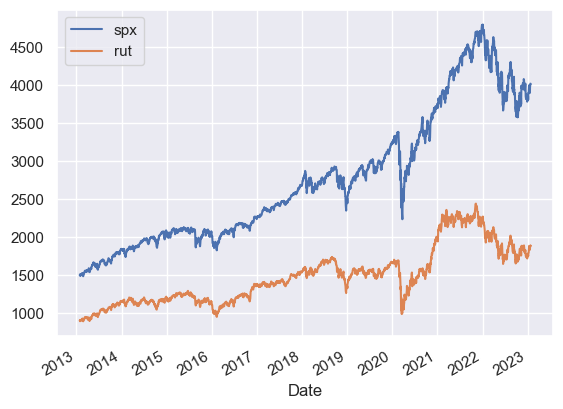

In [6]:
df.plot()

<AxesSubplot: xlabel='Date'>

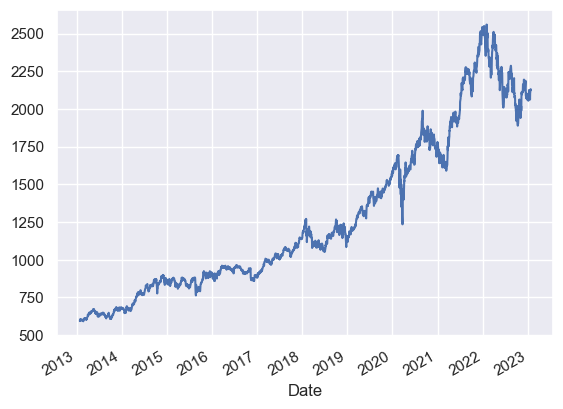

In [15]:
(df.iloc[:,0] - df.iloc[:,1]).plot()

In [22]:
# correlation
def correlation(df):
    return df['spx'].corr(df['rut'])

# Jarque Bera test for normality
# if diff follow normal dist, small p val == normal (i.e. skweness and kurtosis = 0)
def check_normal(df):
    return stats.jarque_bera(df.iloc[:,0] - df.iloc[:,1])

# Augmented Dickey-Fuller test for stationarity (only return test statistic and p val)
# small p val == stationary
def check_stationary(df):
    return [adfuller(df.iloc[:,0])[:2], adfuller(df.iloc[:,1])[:2]]

# check for cointegration
# return t stats and p value
def check_cointegration(df):
    return coint(df.iloc[:,0], df.iloc[:,1])[:2]

# ljung-box test for autocorrelation 
# small p val == autocorrelation
def check_autocorrelation(df):
    return [[acorr_ljungbox(df.iloc[:,0], lags=[1], return_df=True).iloc[0,0], 
             acorr_ljungbox(df.iloc[:,0], lags=[1], return_df=True).iloc[0,1]], 
            [acorr_ljungbox(df.iloc[:,1], lags=[1], return_df=True).iloc[0,0], 
             acorr_ljungbox(df.iloc[:,1], lags=[1], return_df=True).iloc[0,1]]]

# Engle's test for ARCH (only return lagrange multiplier test stat and p val)
# small p val == ARCH effect present
def check_arch(df):
    return [het_arch(df.iloc[:,0])[:2], het_arch(df.iloc[:,1])[:2]]


In [8]:
correlation(df)

0.9546751891778165

In [9]:
check_normal(df)
# normal dist

Jarque_beraResult(statistic=271.6105341398111, pvalue=0.0)

In [10]:
check_stationary(df)
# non-stationary

[(-0.8785868432220219, 0.7949422697274001),
 (-1.6126901271473368, 0.47656360346558674)]

In [28]:
df[:"2019-01-01"]

,spx,rut
Date,,
2013-01-28,1500.18,906.71
2013-01-29,1507.84,907.31
2013-01-30,1501.96,896.91
2013-01-31,1498.11,902.09
2013-02-01,1513.17,911.20
...,...,...
2018-12-24,2351.10,1266.92
2018-12-26,2467.70,1329.81
2018-12-27,2488.83,1331.82


In [30]:
check_cointegration(df)
# no cointegration for full data set

check_cointegration(df[:"2020-01-01"])
# no cointegration for partial data set prior to the pandemic

(-2.3446711951229084, 0.35148680772403185)

(-1.8422512151522676, 0.6089815334211228)

In [10]:
check_autocorrelation(df)
# autocorrelated

[[2512.0942626965702, 0.0], [2508.015775014515, 0.0]]

In [11]:
check_arch(df)
# arch effect present (i.e. clustering of vo)

[(2502.4781182988913, 0.0), (2497.8509657122822, 0.0)]